# 참조

In [1]:
# https://medium.com/coinmonks/how-to-backtest-your-trading-strategy-with-fees-using-pandas-8e5ba1278431

# Define a strategy

이전의 트레이딩 경험 또는 차트분석을 활용해서, 시스템 매매 전략(매매 룰)을 수립하는 것이다.

## Commodity Channel Index (CCI)
- Buy when CCI(100) crosses over 100
- Sell when CCI(100) crosses under 100

# Gather OHLC data and compute the CCI

In [5]:
!pip install yfinance
!pip install ta
# !pip install talib-binary

  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=527bc7fab928d1c6a96b0a16af38272418d6068f5e34e59dffcd92aac7fae548
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


In [6]:
import yfinance as yf
from ta.trend import cci

In [13]:
ETH_ticker = yf.Ticker("BTC-USD")
data = ETH_ticker.history(period="max")
data.drop(["Volume","Dividends","Stock Splits"], axis=1, inplace=True)
data.columns = ["open_price","high_price","low_price","close_price"]
data["cci"] = cci(high=data["high_price"],low=data["low_price"],close=data["close_price"],window=100)

In [14]:
data

,open_price,high_price,low_price,close_price,cci
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,NaN
...,...,...,...,...,...
2022-05-02,38472.187500,39074.972656,38156.562500,38529.328125,-68.065534
2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,-86.578819
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,-55.834222


# Compute position, fees and results

In [15]:
import numpy as np

fee_rate = 0.001 #0.1%

data["pct_change"] = data["close_price"].pct_change()
data["position"] = np.where(data["cci"] >= 100, 1, 0)
data["position"] = data["position"].shift(1)
data.fillna(0, inplace=True)

data["fee_deduction"] = np.where(data["position"] != data["position"].shift(1), 1 - fee_rate, 1)

data["strategy"] = (data["fee_deduction"] * (1 + data["position"] * data["pct_change"])).cumprod()

data["buy&hold"] = (1 + data["pct_change"]).cumprod()
data

,open_price,high_price,low_price,close_price,cci,pct_change,position,fee_deduction,strategy,buy&hold
Date,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,0.000000,0.000000,0.0,0.999,0.999000,1.000000
2014-09-18,456.859985,456.859985,413.104004,424.440002,0.000000,-0.071926,0.0,1.000,0.999000,0.928074
2014-09-19,424.102997,427.834991,384.532013,394.795990,0.000000,-0.069843,0.0,1.000,0.999000,0.863255
2014-09-20,394.673004,423.295990,389.882996,408.903992,0.000000,0.035735,0.0,1.000,0.999000,0.894104
2014-09-21,408.084991,412.425995,393.181000,398.821014,0.000000,-0.024659,0.0,1.000,0.999000,0.872056
...,...,...,...,...,...,...,...,...,...,...
2022-05-02,38472.187500,39074.972656,38156.562500,38529.328125,-68.065534,0.001566,0.0,1.000,96.035528,84.247676
2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,-86.578819,-0.020215,0.0,1.000,96.035528,82.544600
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,-55.834222,0.051600,0.0,1.000,96.035528,86.803889


# Plot our strategy’s performance

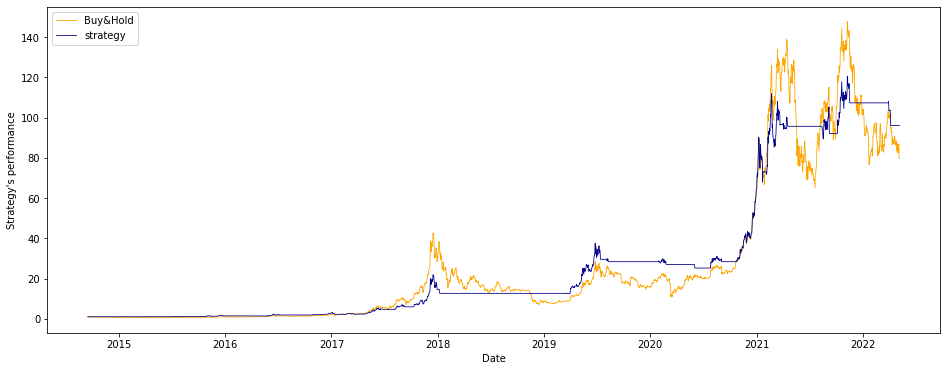

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(data.index, data["buy&hold"], linewidth=0.8, color="orange", label="Buy&Hold")
plt.plot(data.index, data["strategy"], linewidth=0.8, color="darkblue", label="strategy")

plt.xlabel("Date")
plt.ylabel("Strategy's performance")
plt.legend()
plt.show()

# Avoid these traps

# Data Leakage

# Fees

# Limits and further improvements